<a href="https://colab.research.google.com/github/min02choi/Data-Analysis-and-Applications/blob/master/Week14/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. 투표 분류기**

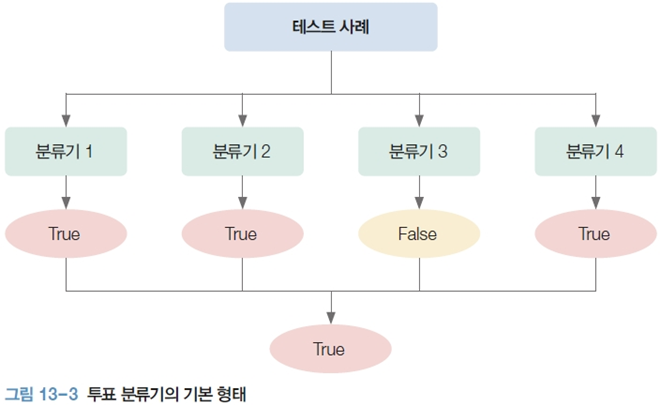

- 투표 분류기를 이용하기 위해서는 ensemble 모듈의 VotingClassifier 이용

In [1]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier

- 이전에 사용한 Titanic Dataset의 전처리 과정을 생략하고, 미리 전처리가 되어있는 파일을 로드

In [2]:
!gdown https://drive.google.com/uc?id=1z9SuxXOXH4G0XwLRpuBvRCtKWgNr0sT7
!gdown https://drive.google.com/uc?id=1vp5JW8T7pFwCYFDV9Ja39aaV_c0VpXpt
X = np.load("titanic_X_train.npy")
y = np.load("titanic_y_train.npy")

Downloading...
From: https://drive.google.com/uc?id=1z9SuxXOXH4G0XwLRpuBvRCtKWgNr0sT7
To: /content/titanic_X_train.npy
100% 192k/192k [00:00<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vp5JW8T7pFwCYFDV9Ja39aaV_c0VpXpt
To: /content/titanic_y_train.npy
100% 7.19k/7.19k [00:00<00:00, 25.1MB/s]


In [3]:
X[0]

array([0.27345609, 0.01415106, 0.        , 1.        , 0.        ,
       0.125     , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [4]:
y[:10]

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1.])

- VotingClassifier의 estimator인자에 ('별명', estimator)의 튜플을 리스트로 넣어줍니다.
- VotingClassifier의 voting 인자를 'soft'할 경우 확률값의 합으로 결정, 'hard'로 할 경우 다수결로 결정합니다.

In [5]:
clf1 = LogisticRegression(random_state=1)
clf2 = DecisionTreeClassifier(random_state=1, max_depth=4)
clf3 = KNeighborsClassifier(n_neighbors=3)

eclf = VotingClassifier(estimators=[('logistic', clf1), ('decisiontree', clf2), ('knn',clf3)], voting='hard')

- 의사결정트리 시간에 배운 N-fold (n=5) Cross Validation으로 성능평가를 수행해보겠습니다.

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(eclf, X, y, cv=5).mean()

0.8346854567383991

In [7]:
cross_val_score(clf1, X, y, cv=5).mean()

0.8290420872214816

In [8]:
cross_val_score(clf2, X, y, cv=5).mean()

0.8223068621849807

In [9]:
cross_val_score(clf3, X, y, cv=5).mean()

0.8065828731035358

- GridSearchCV 클래스를 이용하면 실험적으로 최적의 hyper parameters를 찾을 수 있다.

In [10]:
params ={
    "logistic__penalty" : ["l2"],
    "logistic__C" : [0.1, 5.0],
    "decisiontree__criterion" : ["gini", "entropy"],
    "decisiontree__max_depth" : [5,4],
    "decisiontree__min_samples_leaf": [3,5],
    "knn__n_neighbors": [2,4]
}

In [11]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(X, y)

grid.best_score_

0.8414397257665207

In [12]:
grid.best_params_

{'decisiontree__criterion': 'entropy',
 'decisiontree__max_depth': 4,
 'decisiontree__min_samples_leaf': 5,
 'knn__n_neighbors': 4,
 'logistic__C': 5.0,
 'logistic__penalty': 'l2'}

**2. 배깅과 랜덤포레스트**
- 배깅(bagging) : 부트스트랩 집합이라는 의미의 ‘bootstrap aggregation’의 약자로, 말 그대로 부트스트랩 연산의 집합이라는 개념
- 데이터셋으로부터 부분집합 n개를 추출 → 앙상블 방법과 달리 하나의 모델에 다양한 데이터셋을 넣어서 n개의 모델을 생성

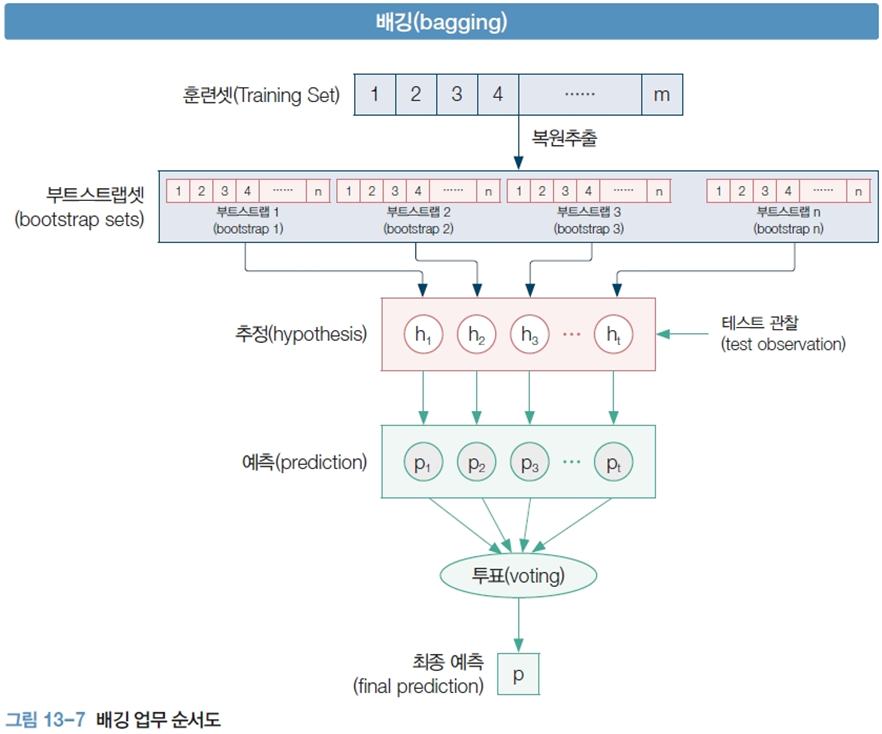

- 랜덤포레스트 배깅 방법을 이용하기 위해서는 ensemble 모듈의 RandomForestClassifier 클래스를 이용
- n_estimators : int, optional(default=10), subset으로 생성되는 모델의 개수
- n_jobs : 병렬 개수, 배깅 알고리즘은 병렬화가 가능하다

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

X = np.load("titanic_X_train.npy")
y = np.load("titanic_y_train.npy")

eclf = RandomForestClassifier(n_estimators=20, n_jobs=7)

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(eclf, X, y, cv=5).mean()

0.7953088300641147

- max_samples : int or float, optional(default=1.0), 최대 데이터 개수 또는 비율
- max_features : int or float, optional(default=1.0), 최대 사용 입력 개수 또는 비율

In [15]:
from sklearn.model_selection import GridSearchCV

params ={
    "max_features" : [0.5, 1.0],
    "max_samples": [0.5, 1.0]
    }

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(X, y)

grid.best_score_

0.8290420872214816

In [16]:
grid.best_params_

{'max_features': 0.5, 'max_samples': 0.5}

**3. 부스팅과 에이다부스트**
- 부스팅(boosting) : 학습 라운드를 차례로 진행하면서 각 예측이 틀린 데이터에 점점 가중치를 주는 방식
- 라운드별로 잘못 분류된 데이터를 좀 더 잘 분류하는 모델로 만들어 최종적으로 모델들의 앙상블을 만드는 방식

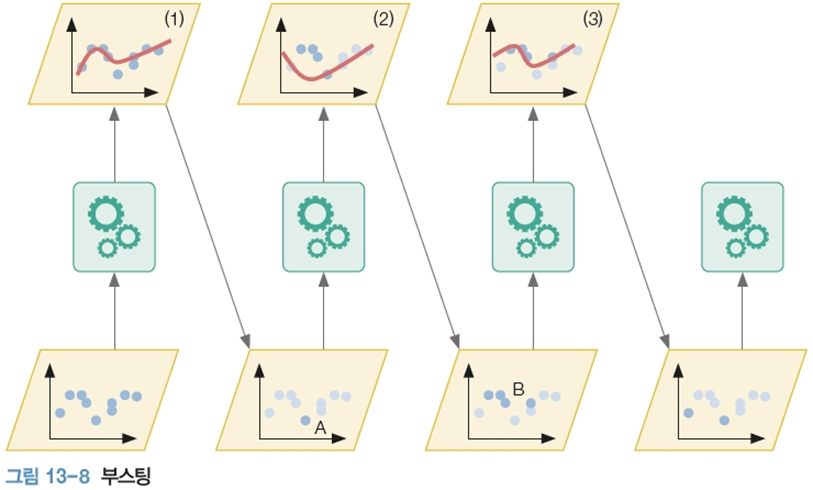

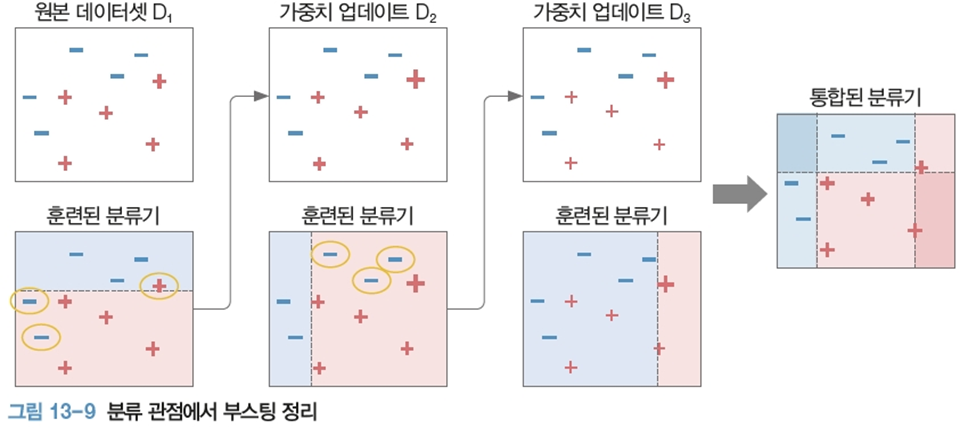

In [17]:
import numpy as np
X = np.load("titanic_X_train.npy")
y = np.load("titanic_y_train.npy")

- n_estimators : int, optional( default=50), 사용되는 모델의 개수

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
eclf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=10)

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(eclf, X, y, cv=5).mean()

0.8121945026344187